In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import sympy as sp
import numpy as np
import control as ctl

# EXTRAINDO OS DADOS

In [13]:
df = pd.read_csv('DataBase.csv')
df = df[['time', 'theta', 'distance']]
df

,time,theta,distance
0,0.00,100,3.69
1,0.00,100,3.67
2,0.01,100,3.69
3,0.01,100,3.69
4,0.01,100,3.67
...,...,...,...
269,4.94,100,19.72
270,4.96,100,19.72
271,4.98,100,19.72
272,5.00,100,19.74


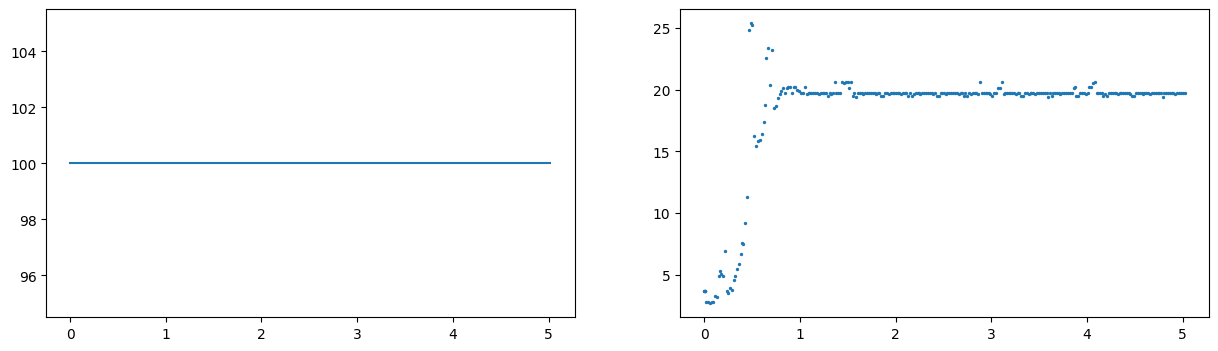

In [14]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(df['time'], df['theta'])

plt.subplot(1, 2, 2)
plt.scatter(df['time'], df['distance'], s=2)

# FILTRANDO OS DADOS

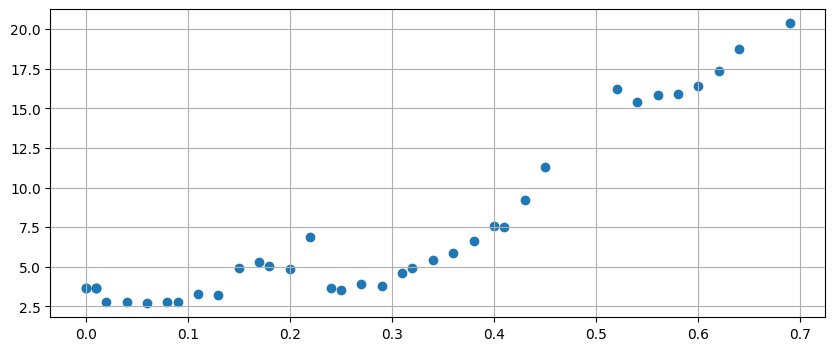

In [15]:
df = df.loc[df['distance'] < 22]
df = df.loc[df['distance'] > 2.5]
df = df.loc[df['time'] < 0.7]

plt.figure(figsize=(10, 4))
plt.scatter(df['time'], df['distance'])
plt.grid()
plt.show()

## FREQUÊNCIA DE AMOSTRAGEM
- Os dados precisam ter uma frequência de amostragem constante

In [16]:
def normalizeData(time, response, T=0.01):
    tData = np.arange(time[0], time[-1], T)
    xData = []
    yData = []

    for i in range(len(tData) - 1):
        currentTime = tData[i]
        nextTime    = tData[i + 1]
        target = response[(time >= currentTime) & (time < nextTime)]

        xData.append(currentTime)
        yData.append(np.mean(target))

    return np.array(xData), np.array(yData)

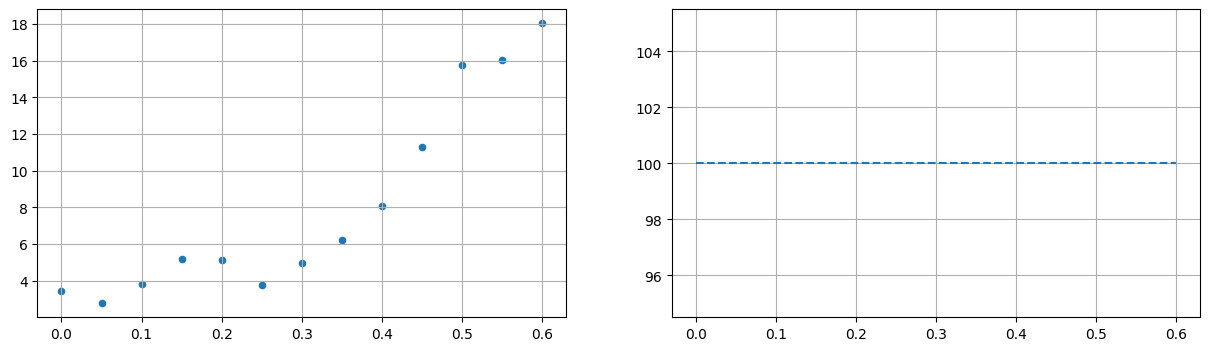

In [17]:
tData, yData = normalizeData(df.time.values, df.distance.values, T=0.05)
tData, uData = normalizeData(df.time.values, df.theta.values, T=0.05)

plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.scatter(tData, yData, s=20)
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(tData, uData, '--')
plt.grid()

# DATA FITTING
O gráfico expressa a função de transferência no domínio do tempo $Y(s) = L^{-1}\{y(t)\}$, podemos encontrar $y(t)$ usando data fitting, encontrando uma função própria que se encaixe nos dados

In [18]:
def g(u, a, b):
    s = ctl.TransferFunction.s
    G = a*s/(s + b)
    return ctl.forced_response(G, T=tData, U=uData)[1]

def getFunction(xDados, yDados):
    coeficientes = curve_fit(g, xDados, yDados, maxfev=1000000000)  # MÁXIMO DE ITERAÇÕES
    return list(coeficientes[0])

In [19]:
coefs = getFunction(uData, yData)  
coefs

[0.021889142438976335, -3.5925259944439967]

In [20]:
s = ctl.TransferFunction.s
a, b = coefs

G = a*s/(s + b)
G

TransferFunction(array([0.02188914, 0.        ]), array([ 1.        , -3.59252599]))

### CONFERINDO COM A DATABASE

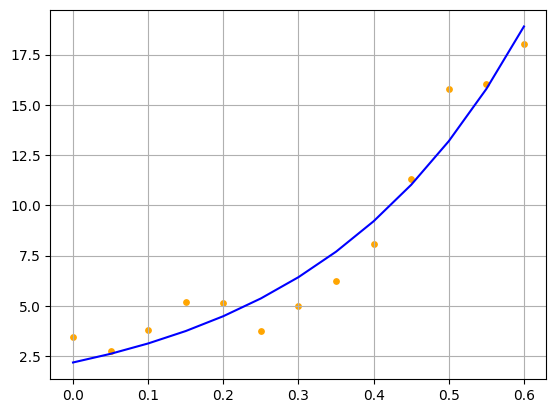

In [21]:
time, response = ctl.forced_response(G, T=tData, U=uData)
plt.plot(time, response, color='blue')
plt.scatter(tData, yData, color='orange', s=15)
plt.grid()

In [22]:
def sympyFunction(tf):
    num, den = ctl.tfdata(tf)
    s = sp.var('s')
    num_expr = sum(coef*s**i for i, coef in enumerate(num[0][0][::-1]))
    den_expr = sum(coef*s**i for i, coef in enumerate(den[0][0][::-1]))
    sympy_system = num_expr/den_expr
    return sympy_system

def roundSympyFunction(expr, num_digits=4):
    return expr.xreplace({n: round(n, num_digits) for n in expr.atoms(sp.Float)})

print(sympyFunction(G))

0.0218891424389763*s/(1.0*s - 3.592525994444)


: 